In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:

class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, learning_rate=0.001, momentum=0.9):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        # Initialize weights with Xavier initialization
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 
                             np.sqrt(2.0 / (n_visible + n_hidden)))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        
        # Momentum parameters
        self.register_buffer('W_momentum', torch.zeros_like(self.W))
        self.register_buffer('v_bias_momentum', torch.zeros_like(self.v_bias))
        self.register_buffer('h_bias_momentum', torch.zeros_like(self.h_bias))
        
    def sample_h(self, v):
        h_activation = torch.mm(v, self.W) + self.h_bias
        h_prob = torch.sigmoid(h_activation)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample
    
    def sample_v(self, h):
        v_activation = torch.mm(h, self.W.t()) + self.v_bias
        v_prob = torch.sigmoid(v_activation)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample
    
    def forward(self, v):
        h_prob, _ = self.sample_h(v)
        return h_prob
    
    def contrastive_divergence(self, v, k=1):
        batch_size = v.size(0)
        
        # Positive phase
        h_prob_pos, h_sample_pos = self.sample_h(v)
        
        # Negative phase (k-step Gibbs sampling)
        h_sample = h_sample_pos
        for _ in range(k):
            v_prob_neg, v_sample_neg = self.sample_v(h_sample)
            h_prob_neg, h_sample = self.sample_h(v_sample_neg)
        
        # Calculate gradients
        positive_grad = torch.mm(v.t(), h_prob_pos) / batch_size
        negative_grad = torch.mm(v_sample_neg.t(), h_prob_neg) / batch_size
        
        w_grad = positive_grad - negative_grad
        v_bias_grad = torch.mean(v - v_sample_neg, dim=0)
        h_bias_grad = torch.mean(h_prob_pos - h_prob_neg, dim=0)
        
        # Apply momentum
        self.W_momentum.data = self.momentum * self.W_momentum + w_grad
        self.v_bias_momentum.data = self.momentum * self.v_bias_momentum + v_bias_grad
        self.h_bias_momentum.data = self.momentum * self.h_bias_momentum + h_bias_grad
        
        # Update parameters with momentum
        self.W.data += self.learning_rate * self.W_momentum
        self.v_bias.data += self.learning_rate * self.v_bias_momentum
        self.h_bias.data += self.learning_rate * self.h_bias_momentum
        
        # Calculate reconstruction error
        error = torch.mean((v - v_sample_neg) ** 2)
        return error

In [53]:

class MovieRecommenderRBM:
    def __init__(self, n_hidden=250, learning_rate=0.005, n_epochs=120, 
                 batch_size=32, k=2, momentum=0.9):
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.k = k
        self.momentum = momentum
        
        self.rbm = None
        self.training_errors = []
        
    def load_data(self, base_dir=""):
        # Load binary rating matrix
        binary_matrix_path = os.path.join(base_dir, "user_movie_binary_matrix.csv")
        self.rating_matrix = pd.read_csv(binary_matrix_path, index_col=0)
        
        # Load additional data for movie information
        self.movies = pd.read_csv(os.path.join(base_dir, "movies.csv"))
        self.ratings = pd.read_csv(os.path.join(base_dir, "ratings.csv"))
        
        # Create mappings
        self.movie_ids = self.rating_matrix.columns.values.astype(int)
        self.user_ids = self.rating_matrix.index.values.astype(int)
        
        self.movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(self.movie_ids)}
        self.idx_to_movie_id = {idx: movie_id for idx, movie_id in enumerate(self.movie_ids)}
        self.user_id_to_idx = {user_id: idx for idx, user_id in enumerate(self.user_ids)}
        self.idx_to_user_id = {idx: user_id for idx, user_id in enumerate(self.user_ids)}
        
        # Convert to numpy array
        self.data = self.rating_matrix.values.astype(np.float32)
        self.data = np.nan_to_num(self.data, nan=0.0)
        
        print(f"Total Users: {len(self.user_ids):,}")
        print(f"Total Movies: {len(self.movie_ids):,}")
        print(f"Total Ratings: {np.sum(self.data > 0):,}")
        print(f"Data Shape: {self.data.shape}")
        
        sparsity = (1 - np.count_nonzero(self.data) / self.data.size) * 100
        print(f"Data Sparsity: {sparsity:.2f}%")
        print(f"Density: {100-sparsity:.2f}%")
        
        return self.data
    
    def prepare_train_test_split(self, test_ratio=0.25):
        self.train_data = self.data.copy()
        self.test_data = np.zeros_like(self.data)
        
        test_count = 0
        users_with_test = 0
        
        # Create test set by hiding some ratings from each user
        for user_idx in range(len(self.user_ids)):
            user_ratings = self.data[user_idx]
            rated_indices = np.where(user_ratings > 0)[0]
            
            if len(rated_indices) >= 6:  # Only for users with at least 6 ratings
                n_test = max(2, int(len(rated_indices) * test_ratio))
                test_indices = np.random.choice(rated_indices, n_test, replace=False)
                
                # Move ratings to test set
                self.test_data[user_idx, test_indices] = user_ratings[test_indices]
                self.train_data[user_idx, test_indices] = 0
                
                test_count += len(test_indices)
                users_with_test += 1
        
        train_count = np.sum(self.train_data > 0)
        
        print(f"Training Data Count: {train_count:,}")
        print(f"Test Data Count: {test_count:,}")
        print(f"Users with Test Data: {users_with_test:,}")
        print(f"Train/Test Ratio: {train_count/(train_count+test_count):.2f}/{test_count/(train_count+test_count):.2f}")
        
        return self.train_data, self.test_data
    
    def prepare_validation_split(self, validation_ratio=0.2):
        # Split training data into train and validation
        train_data, val_data = train_test_split(
            self.train_data, test_size=validation_ratio, random_state=42
        )
        
        print(f"Final Training Data Count: {np.sum(train_data > 0):,}")
        print(f"Validation Data Count: {np.sum(val_data > 0):,}")
      
        # data loaders
        train_tensor = torch.FloatTensor(train_data)
        val_tensor = torch.FloatTensor(val_data)
        
        train_dataset = TensorDataset(train_tensor)
        val_dataset = TensorDataset(val_tensor)
        
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        print(f"Training Batches: {len(self.train_loader)}")
        print(f"Validation Batches: {len(self.val_loader)}")
        
        return train_tensor, val_tensor
    
    def train_model(self):
        # Initialize RBM
        n_visible = self.data.shape[1]
        self.rbm = RBM(n_visible, self.n_hidden, self.learning_rate, self.momentum)
        
        # Training loop with learning rate scheduling
        best_error = float('inf')
        patience = 0
        max_patience = 15
        
        for epoch in range(self.n_epochs):
            train_error = 0
            train_batches = 0
            
            for batch_data, in self.train_loader:
                # Only train on users who have rated movies
                mask = torch.sum(batch_data, dim=1) > 0
                if mask.sum() == 0:
                    continue
                
                batch_data = batch_data[mask]
                error = self.rbm.contrastive_divergence(batch_data, self.k)
                
                train_error += error.item()
                train_batches += 1
            
            avg_error = train_error / max(train_batches, 1)
            self.training_errors.append(avg_error)
            
            # Learning rate decay
            if epoch > 0 and epoch % 30 == 0:
                self.rbm.learning_rate *= 0.95
            
            # Early stopping
            if avg_error < best_error:
                best_error = avg_error
                patience = 0
            else:
                patience += 1
            
            if patience >= max_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
            
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:3d}/{self.n_epochs} - Training Error: {avg_error:.4f} - LR: {self.rbm.learning_rate:.5f}")
        
        print("\nTraining completed successfully!")
    
    def get_recommendations(self, user_id, n_recommendations=10, diversity_factor=0.1):
        if user_id not in self.user_id_to_idx:
            print(f"User {user_id} not found in dataset")
            return []
        
        user_idx = self.user_id_to_idx[user_id]
        user_ratings = torch.FloatTensor(self.train_data[user_idx:user_idx+1])
        
        if torch.sum(user_ratings) == 0:
            print(f"User {user_id} has no ratings in training data")
            return []
        
        # Get multiple predictions for better stability
        self.rbm.eval()
        predictions = []
        
        with torch.no_grad():
            for _ in range(5):  # Average multiple predictions
                h_prob, _ = self.rbm.sample_h(user_ratings)
                v_prob, _ = self.rbm.sample_v(h_prob)
                predictions.append(v_prob.numpy()[0])
        
        # Average predictions
        predicted_ratings = np.mean(predictions, axis=0)
        
        # Calculate item popularity for diversity
        item_popularity = np.sum(self.train_data, axis=0)
        max_popularity = np.max(item_popularity)
        
        # Get movies user hasn't rated
        user_rated_movies = self.train_data[user_idx] > 0
        unrated_movies = ~user_rated_movies
        
        # Create recommendation list with diversity boost
        recommendations = []
        for movie_idx in range(len(predicted_ratings)):
            if unrated_movies[movie_idx]:
                movie_id = self.idx_to_movie_id[movie_idx]
                movie_info = self.movies[self.movies['movie_id'] == movie_id]
                
                if not movie_info.empty:
                    base_score = predicted_ratings[movie_idx]
                    
                    # Add diversity boost (boost less popular items)
                    popularity_penalty = (item_popularity[movie_idx] / max_popularity) * diversity_factor
                    final_score = base_score - popularity_penalty
                    
                    recommendations.append({
                        'movie_id': movie_id,
                        'movie_title': movie_info.iloc[0]['movie_title'],
                        'predicted_score': final_score
                    })
        
        # Sort by predicted score and return top N
        recommendations.sort(key=lambda x: x['predicted_score'], reverse=True)
        return recommendations[:n_recommendations]
    
    def calculate_precision_at_k(self, user_id, k=10):
        if user_id not in self.user_id_to_idx:
            return 0.0
        
        user_idx = self.user_id_to_idx[user_id]
        test_items = set(np.where(self.test_data[user_idx] > 0)[0])
        
        if len(test_items) == 0:
            return 0.0
        
        recommendations = self.get_recommendations(user_id, n_recommendations=k)
        if len(recommendations) == 0:
            return 0.0
        
        recommended_items = set([self.movie_id_to_idx[rec['movie_id']] for rec in recommendations])
        relevant_recommended = len(test_items.intersection(recommended_items))
        
        return relevant_recommended / min(k, len(recommendations))
    
    def calculate_recall_at_k(self, user_id, k=10):
        # Recall@K for a user
        if user_id not in self.user_id_to_idx:
            return 0.0
        
        user_idx = self.user_id_to_idx[user_id]
        test_items = set(np.where(self.test_data[user_idx] > 0)[0])
        
        if len(test_items) == 0:
            return 0.0
        
        recommendations = self.get_recommendations(user_id, n_recommendations=k)
        if len(recommendations) == 0:
            return 0.0
        
        recommended_items = set([self.movie_id_to_idx[rec['movie_id']] for rec in recommendations])
        relevant_recommended = len(test_items.intersection(recommended_items))
        
        return relevant_recommended / len(test_items)
    
    def calculate_ndcg_at_k(self, user_id, k=10):
        # NDCG@K for a user
        if user_id not in self.user_id_to_idx:
            return 0.0
        
        user_idx = self.user_id_to_idx[user_id]
        test_items = np.where(self.test_data[user_idx] > 0)[0]
        
        if len(test_items) == 0:
            return 0.0
        
        recommendations = self.get_recommendations(user_id, n_recommendations=k)
        if len(recommendations) == 0:
            return 0.0
        
        # Calculate DCG
        dcg = 0.0
        for i, rec in enumerate(recommendations):
            movie_idx = self.movie_id_to_idx[rec['movie_id']]
            if movie_idx in test_items:
                dcg += 1.0 / np.log2(i + 2)
        
        # Calculate IDCG (perfect ranking)
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(k, len(test_items))))
        
        return dcg / idcg if idcg > 0 else 0.0
    
    # Evaluate model with Precision@K, Recall@K, and NDCG@K
    def evaluate_model(self, k_values=[5, 10, 20], n_test_users=200):

        # Find users with both training and test data
        valid_users = []
        for user_id in self.user_ids:
            user_idx = self.user_id_to_idx[user_id]
            if (np.sum(self.train_data[user_idx]) >= 3 and  # At least 3 training ratings
                np.sum(self.test_data[user_idx]) >= 1):     # At least 1 test rating
                valid_users.append(user_id)
        
        if len(valid_users) == 0:
            print("No valid users found for evaluation!")
            return {}
        
        # Sample test users
        test_users = np.random.choice(
            valid_users, 
            min(n_test_users, len(valid_users)), 
            replace=False
        )
        
        print(f"Evaluating on {len(test_users)} users...")
        
        results = {}
        
        for k in k_values:
            print(f"\nCalculating metrics for K = {k}...")
            
            precisions = []
            recalls = []
            ndcgs = []
            
            for i, user_id in enumerate(test_users):
                if (i + 1) % 50 == 0:
                    print(f"  Progress: {i+1}/{len(test_users)} users")
                
                precision = self.calculate_precision_at_k(user_id, k)
                recall = self.calculate_recall_at_k(user_id, k)
                ndcg = self.calculate_ndcg_at_k(user_id, k)
                
                precisions.append(precision)
                recalls.append(recall)
                ndcgs.append(ndcg)
            
            results[k] = {
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'ndcg': np.mean(ndcgs),
                'precision_std': np.std(precisions),
                'recall_std': np.std(recalls),
                'ndcg_std': np.std(ndcgs)
            }
            
            print(f"  Precision@{k}: {results[k]['precision']:.4f} ± {results[k]['precision_std']:.4f}")
            print(f"  Recall@{k}: {results[k]['recall']:.4f} ± {results[k]['recall_std']:.4f}")
            print(f"  NDCG@{k}: {results[k]['ndcg']:.4f} ± {results[k]['ndcg_std']:.4f}")
        
        self.evaluation_results = results
        return results
    
    def plot_training_progress(self):
        # Plot training progress
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.training_errors) + 1), self.training_errors, 'b-', linewidth=2)
        plt.title('RBM Training Progress', fontsize=16, fontweight='bold')
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Training Error', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_evaluation_metrics(self):
        # metrics
        k_values = list(self.evaluation_results.keys())
        precisions = [self.evaluation_results[k]['precision'] for k in k_values]
        recalls = [self.evaluation_results[k]['recall'] for k in k_values]
        ndcgs = [self.evaluation_results[k]['ndcg'] for k in k_values]
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Precision@K
        axes[0].bar([f'P@{k}' for k in k_values], precisions, color='skyblue', alpha=0.8)
        axes[0].set_title('Precision@K', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Precision', fontsize=12)
        axes[0].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(precisions):
            axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Recall@K
        axes[1].bar([f'R@{k}' for k in k_values], recalls, color='lightcoral', alpha=0.8)
        axes[1].set_title('Recall@K', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Recall', fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(recalls):
            axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # NDCG@K
        axes[2].bar([f'N@{k}' for k in k_values], ndcgs, color='lightgreen', alpha=0.8)
        axes[2].set_title('NDCG@K', fontsize=14, fontweight='bold')
        axes[2].set_ylabel('NDCG', fontsize=12)
        axes[2].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(ndcgs):
            axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def print_evaluation_summary(self):
        print(f"{'K':>3} {'Precision@K':>12} {'Recall@K':>12} {'NDCG@K':>12}")
        print("\n")
        
        for k in sorted(self.evaluation_results.keys()):
            precision = self.evaluation_results[k]['precision']
            recall = self.evaluation_results[k]['recall']
            ndcg = self.evaluation_results[k]['ndcg']
            
            print(f"{k:>3} {precision:>12.4f} {recall:>12.4f} {ndcg:>12.4f}")
        
        # Calculate average metrics
        avg_precision = np.mean([self.evaluation_results[k]['precision'] for k in self.evaluation_results.keys()])
        avg_recall = np.mean([self.evaluation_results[k]['recall'] for k in self.evaluation_results.keys()])
        avg_ndcg = np.mean([self.evaluation_results[k]['ndcg'] for k in self.evaluation_results.keys()])
        
        print("-" * 70)
        print(f"{'AVG':>3} {avg_precision:>12.4f} {avg_recall:>12.4f} {avg_ndcg:>12.4f}")
        print("=" * 70)
    
    def get_user_top_movies(self, user_id, n_movies=5):
        # Get top rated movies for a user
        if user_id not in self.user_id_to_idx:
            print(f"User {user_id} not found in dataset")
            return []
        
        # Get original ratings from the ratings dataset
        user_ratings = self.ratings[self.ratings['user_id'] == user_id]
        
        if user_ratings.empty:
            print(f"No ratings found for user {user_id}")
            return []
        
        # Sort by rating and get top movies
        top_ratings = user_ratings.nlargest(n_movies, 'rating')
        
        top_movies = []
        for _, rating_row in top_ratings.iterrows():
            movie_id = rating_row['movie_id']
            movie_info = self.movies[self.movies['movie_id'] == movie_id]
            
            if not movie_info.empty:
                top_movies.append({
                    'movie_id': movie_id,
                    'movie_title': movie_info.iloc[0]['movie_title'],
                    'rating': rating_row['rating']
                })
        
        return top_movies
    
    def recommendation_demo(self, user_id=None):
        # Demo recommendation system for a user
        if user_id is None:
            # Find a user with good rating history
            for uid in self.user_ids[:50]:  # Check first 50 users
                user_idx = self.user_id_to_idx[uid]
                if (np.sum(self.train_data[user_idx]) >= 10 and  # Has enough training data
                    len(self.get_user_top_movies(uid)) >= 5):    # Has enough original ratings
                    user_id = uid
                    break
        
        if user_id is None:
            user_id = self.user_ids[0]  # Fallback to first user
        
        print("=" * 80)
        print("MOVIE RECOMMENDATION DEMO")
        print("=" * 80)
        print(f"User ID: {user_id}")
        
        # Show top 5 rated movies
        top_movies = self.get_user_top_movies(user_id, n_movies=5)
        
        print(f"\nTop 5 Highest Rated Movies by User {user_id}:")
        if top_movies:
            for i, movie in enumerate(top_movies, 1):
                print(f"{i}. {movie['movie_title']}")
                print(f"   Rating: {movie['rating']}/5.0")
                print()
        else:
            print("No rating history found for this user.")
        
        # Get recommendations
        recommendations = self.get_recommendations(user_id, n_recommendations=10)
        
        print(f"Top 10 Movie Recommendations for User {user_id}:")
        print("-" * 60)
        if recommendations:
            for i, rec in enumerate(recommendations, 1):
                print(f"{i:2d}. {rec['movie_title']}")
                print(f"    Predicted Score: {rec['predicted_score']:.4f}")
                print()
        else:
            print("No recommendations could be generated for this user.")
        
        return user_id, top_movies, recommendations
    
    def interactive_recommendation_demo(self):
        print()
        print("INTERACTIVE MOVIE RECOMMENDATION DEMO")
        print()
        print(f"Available User IDs range from {min(self.user_ids)} to {max(self.user_ids)}")
        print(f"Total users in dataset: {len(self.user_ids):,}")
        
        while True:
            try:
                # Get user input for user ID
                user_input = input(f"\nEnter a User ID (or 'quit' to exit): ").strip()
                
                if user_input.lower() in ['quit', 'exit', 'q']:
                    print("Thank you for using the recommendation system!")
                    break
                
                # Convert to integer
                requested_user_id = int(user_input)
                
                # Check if user exists
                if requested_user_id not in self.user_ids:
                    print(f" User ID {requested_user_id} not found in dataset.")
                    print(f"Please enter a valid User ID between {min(self.user_ids)} and {max(self.user_ids)}")
                    continue
                
                # Check if user has sufficient data
                user_idx = self.user_id_to_idx[requested_user_id]
                train_ratings = np.sum(self.train_data[user_idx])
                original_ratings = len(self.get_user_top_movies(requested_user_id))
                
                if train_ratings < 3:
                    print(f"  User {requested_user_id} has insufficient training data ({train_ratings} ratings).")
                    print("Recommendations may not be accurate. Trying anyway...")
                elif original_ratings < 3:
                    print(f"  User {requested_user_id} has limited rating history ({original_ratings} ratings).")
                    print("Trying to generate recommendations anyway...")
                
                # Generate and display recommendations
                self.show_user_recommendations(requested_user_id)
                
                # Ask if they want to see another user's recommendations
                while True:
                    continue_choice = input("\nWould you like to see recommendations for another user? (yes/no): ").strip().lower()
                    
                    if continue_choice in ['yes', 'y']:
                        break  # Continue to outer loop
                    elif continue_choice in ['no', 'n']:
                        print("Thank you for using the recommendation system!")
                        return
                    else:
                        print("Please enter 'yes' or 'no'")
                        
            except ValueError:
                print(" Please enter a valid numeric User ID.")
            except KeyboardInterrupt:
                print("\n\nGoodbye!")
                break
            except Exception as e:
                print(f" An error occurred: {e}")
                print("Please try again.")   
     
    def get_rbm_movie_recommendations(self, movie_inputs, n_recommendations=10, return_dataframe=True):
        if not isinstance(movie_inputs, (list, tuple)):
            movie_inputs = [movie_inputs]
        
        print(f"Recommendations based on {len(movie_inputs)} movie(s)...")
        
        valid_movies = []
        synthetic_user_profile = np.zeros(len(self.movie_ids), dtype=np.float32)
        
        for movie_input in movie_inputs:
            target_movie_id, target_movie_title, _ = self._process_single_movie(movie_input)
            
            if target_movie_id is not None:
                valid_movies.append({
                    'id': target_movie_id,
                    'title': target_movie_title
                })
                movie_idx = self.movie_id_to_idx[target_movie_id]
                synthetic_user_profile[movie_idx] = 1.0
        
        if not valid_movies:
            print("No valid movies found in the input")
            return pd.DataFrame() if return_dataframe else []
                
        # RBM to predict ratings
        self.rbm.eval()
        user_tensor = torch.FloatTensor(synthetic_user_profile).unsqueeze(0)
        
        # Get multiple predictions for stability 
        predictions = []
        with torch.no_grad():
            for _ in range(5):
                h_prob, _ = self.rbm.sample_h(user_tensor)
                v_prob, _ = self.rbm.sample_v(h_prob)
                predictions.append(v_prob.numpy()[0])
        
        # Average predictions
        predicted_ratings = np.mean(predictions, axis=0)
        
        input_movie_indices = {self.movie_id_to_idx[movie['id']] for movie in valid_movies}
        
        recommendations_data = []
        movie_scores = []
        
        for movie_idx in range(len(predicted_ratings)):
            if movie_idx not in input_movie_indices: 
                movie_id = self.idx_to_movie_id[movie_idx]
                predicted_score = predicted_ratings[movie_idx]
                movie_scores.append((movie_idx, movie_id, predicted_score))
        
        movie_scores.sort(key=lambda x: x[2], reverse=True)

        # Get top N recommendations
        for rank, (movie_idx, movie_id, score) in enumerate(movie_scores[:n_recommendations], 1):
            movie_info = self.movies[self.movies['movie_id'] == movie_id]
            
            if not movie_info.empty:
                movie_popularity = int(np.sum(self.data[:, movie_idx]))
                
                recommendations_data.append({
                    'Rank': rank,
                    'Movie_ID': movie_id,
                    'Movie_Title': movie_info.iloc[0]['movie_title'],
                    'Movie_Popularity': movie_popularity,
                    'Prediction_Confidence': round(float(score), 4)  # Using score as confidence
                })
        
        if return_dataframe:
            df = pd.DataFrame(recommendations_data)
            return df
        else:
            recommendations = []
            for rec in recommendations_data:
                recommendations.append({
                    'movie_id': rec['Movie_ID'],
                    'movie_title': rec['Movie_Title'],
                    'predicted_score': rec['RBM_Predicted_Score'],
                    'movie_popularity': rec['Movie_Popularity']
                })
            return recommendations

    def _process_single_movie(self, movie_input):
        target_movie_id = None
        target_movie_title = None
        
        if isinstance(movie_input, str):
            movie_matches = self.movies[
                self.movies['movie_title'].str.contains(movie_input, case=False, na=False)
            ]
            
            if movie_matches.empty:
                print(f"No movies found matching '{movie_input}'")
                return None, None, []
            
            if len(movie_matches) > 1:
                print(f"Multiple movies found matching '{movie_input}':")
                for idx, row in movie_matches.head(3).iterrows():
                    print(f"  - {row['movie_title']} (ID: {row['movie_id']})")
            
            target_movie_id = movie_matches.iloc[0]['movie_id']
            target_movie_title = movie_matches.iloc[0]['movie_title']
            
        else:
            movie_info = self.movies[self.movies['movie_id'] == movie_input]
            if movie_info.empty:
                print(f"Movie with ID {movie_input} not found")
                return None, None, []
            
            target_movie_id = movie_input
            target_movie_title = movie_info.iloc[0]['movie_title']
        
        # Check if movie exists 
        if target_movie_id not in self.movie_id_to_idx:
            print(f"Movie '{target_movie_title}' (ID: {target_movie_id}) not found in rating matrix")
            return None, None, []
        
        target_movie_idx = self.movie_id_to_idx[target_movie_id]
        
        target_movie_ratings = self.data[:, target_movie_idx]
        users_who_liked = np.where(target_movie_ratings > 0)[0].tolist()
        
        if len(users_who_liked) == 0:
            print(f"No users found who rated '{target_movie_title}' positively")
            return target_movie_id, target_movie_title, []
        
        print(f"  {len(users_who_liked)} users liked this movie")
        return target_movie_id, target_movie_title, users_who_liked


In [55]:
recommender = MovieRecommenderRBM(
    n_hidden=250,          
    learning_rate=0.005,   
    n_epochs=120,          
    batch_size=32,         
    k=2,                   
    momentum=0.9
)

In [56]:
data = recommender.load_data()

Total Users: 943
Total Movies: 1,682
Total Ratings: 55,375
Data Shape: (943, 1682)
Data Sparsity: 96.51%
Density: 3.49%


In [57]:
train_data, test_data = recommender.prepare_train_test_split(test_ratio=0.25)

Training Data Count: 41,885
Test Data Count: 13,490
Users with Test Data: 934
Train/Test Ratio: 0.76/0.24


In [58]:
train_tensor, val_tensor = recommender.prepare_validation_split(validation_ratio=0.2)


Final Training Data Count: 33,634
Validation Data Count: 8,251
Training Batches: 24
Validation Batches: 6


In [59]:
recommender.train_model()

Epoch   1/120 - Training Error: 0.3526 - LR: 0.00500
Epoch  20/120 - Training Error: 0.0428 - LR: 0.00500
Epoch  40/120 - Training Error: 0.0398 - LR: 0.00475
Epoch  60/120 - Training Error: 0.0378 - LR: 0.00475
Epoch  80/120 - Training Error: 0.0359 - LR: 0.00451
Epoch 100/120 - Training Error: 0.0334 - LR: 0.00429
Epoch 120/120 - Training Error: 0.0310 - LR: 0.00429

Training completed successfully!


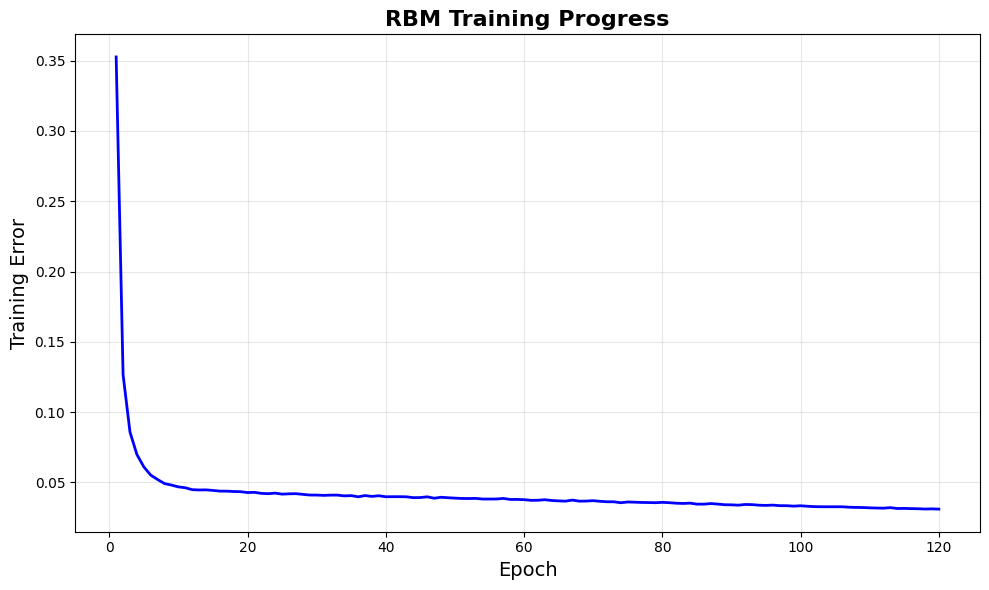

In [60]:
recommender.plot_training_progress()

In [ ]:
evaluation_results = recommender.evaluate_model(
    k_values=[5, 10, 15, 20], 
    n_test_users=200
)

Evaluating on 200 users...

Calculating metrics for K = 5...


In [11]:
recommender.print_evaluation_summary()

  K  Precision@K     Recall@K       NDCG@K


  5       0.2210       0.1225       0.2579
 10       0.1940       0.2082       0.2662
 15       0.1737       0.2696       0.2782
 20       0.1550       0.3142       0.2870
----------------------------------------------------------------------
AVG       0.1859       0.2286       0.2724


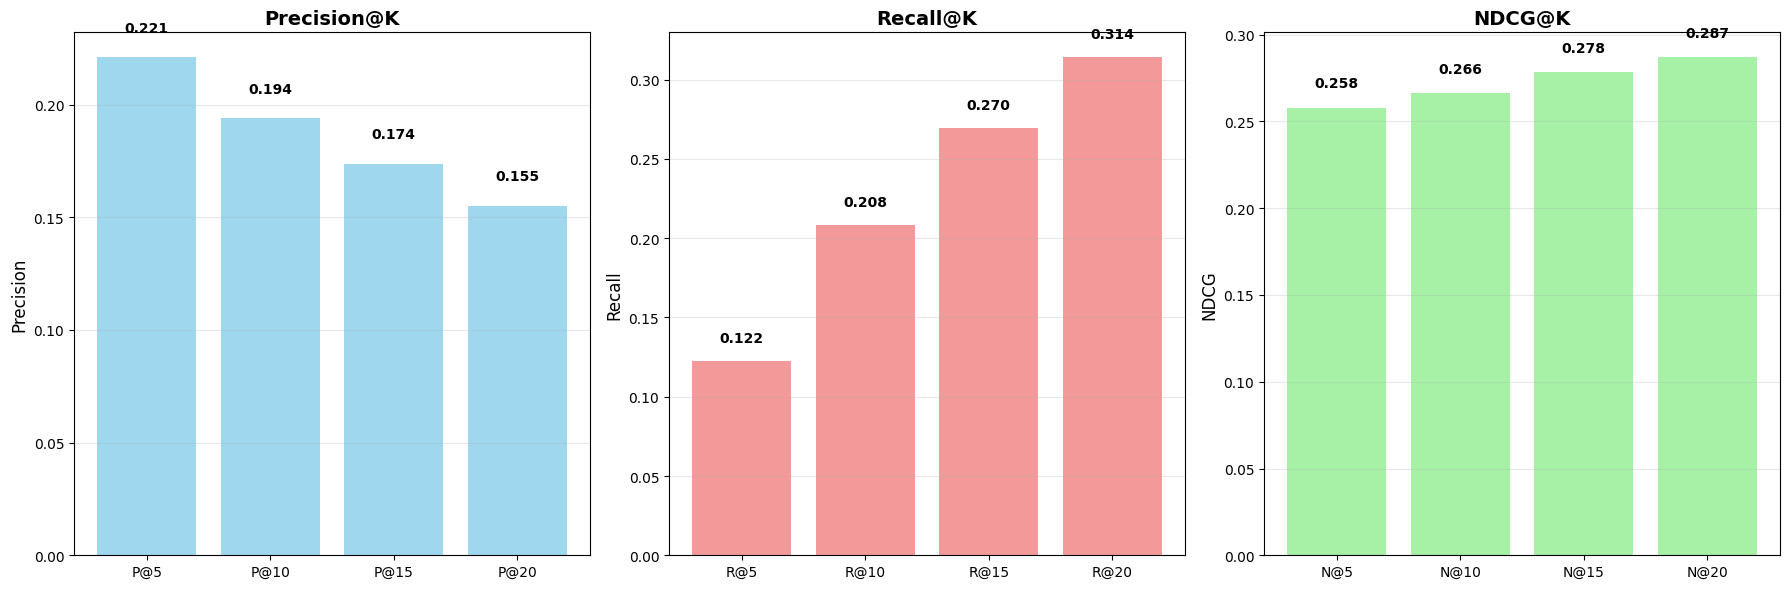

In [12]:
recommender.plot_evaluation_metrics()

In [13]:
user_id, top_movies, recommendations = recommender.recommendation_demo()
    

MOVIE RECOMMENDATION DEMO
User ID: 1

Top 5 Highest Rated Movies by User 1:
1. Groundhog Day (1993)
   Rating: 5/5.0

2. Delicatessen (1991)
   Rating: 5/5.0

3. Pillow Book, The (1995)
   Rating: 5/5.0

4. Horseman on the Roof, The (Hussard sur le toit, Le) (1995)
   Rating: 5/5.0

5. Shawshank Redemption, The (1994)
   Rating: 5/5.0

Top 10 Movie Recommendations for User 1:
------------------------------------------------------------
 1. Rumble in the Bronx (1995)
    Predicted Score: 0.6321

 2. Godfather, The (1972)
    Predicted Score: 0.6053

 3. Schindler's List (1993)
    Predicted Score: 0.4697

 4. Clockwork Orange, A (1971)
    Predicted Score: 0.4559

 5. Four Weddings and a Funeral (1994)
    Predicted Score: 0.3696

 6. Chasing Amy (1997)
    Predicted Score: 0.3670

 7. Muriel's Wedding (1994)
    Predicted Score: 0.3643

 8. Highlander (1986)
    Predicted Score: 0.3456

 9. Star Trek: First Contact (1996)
    Predicted Score: 0.3401

10. Like Water For Chocolate (Como 

In [ ]:
recommender.interactive_recommendation_demo()


INTERACTIVE MOVIE RECOMMENDATION DEMO

Available User IDs range from 1 to 943
Total users in dataset: 943

RECOMMENDATIONS FOR USER 5

  Top 5 Highest Rated Movies by User 5:
------------------------------------------------------------
1.  Adventures of Priscilla, Queen of the Desert, The (1994)
    Rating: 5/5.0

2.  American Werewolf in London, An (1981)
    Rating: 5/5.0

3.  Clerks (1994)
    Rating: 5/5.0

4.  Fish Called Wanda, A (1988)
    Rating: 5/5.0

5.  Mystery Science Theater 3000: The Movie (1996)
    Rating: 5/5.0

 User Statistics:
   • Training ratings: 44
   • Test ratings: 14
   • Total original ratings: 5

 Top 10 Movie Recommendations for User 5:
------------------------------------------------------------
 1.  Brazil (1985)
     Predicted Score: 0.6344

 2.  Willy Wonka and the Chocolate Factory (1971)
     Predicted Score: 0.5902

 3.  Indiana Jones and the Last Crusade (1989)
     Predicted Score: 0.5571

 4.  Fifth Element, The (1997)
     Predicted Score: 0.5

In [51]:
recs = recommender.get_rbm_movie_recommendations(["Toy Story", "Matrix", "Get Shorty "])
recs

Recommendations based on 3 movie(s)...
✓ Found: 'Toy Story (1995)' (ID: 1)
  321 users liked this movie
No movies found matching 'Matrix'
✓ Found: 'Get Shorty (1995)' (ID: 4)
  122 users liked this movie

Top 10 RBM-based movie recommendations:


,Rank,Movie_ID,Movie_Title,RBM_Predicted_Score,Movie_Popularity,Prediction_Confidence
0,1,300,Air Force One (1997),0.0566,252,0.0566
1,2,258,Contact (1997),0.0477,344,0.0477
2,3,288,Scream (1996),0.0411,246,0.0411
3,4,294,Liar Liar (1997),0.0382,197,0.0382
4,5,15,Mr. Holland's Opus (1995),0.0346,188,0.0346
5,6,50,Star Wars (1977),0.0340,501,0.0340
6,7,321,Mother (1996),0.0324,57,0.0324
7,8,100,Fargo (1996),0.0287,406,0.0287
8,9,313,Titanic (1997),0.0264,284,0.0264
9,10,269,"Full Monty, The (1997)",0.0237,222,0.0237
